# Example 1 - Detection and quantification in Brightfield

xxx

## 1. Imports

In [1]:
import sys
sys.path.insert(0, "../") # Adds the module to path
import deeptrack as dt

In [2]:
import deeplay as dl

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Detection in brightfield

xxx

In [254]:
data = np.load("../data/brightfield_data.npy")
labels = np.load("../data/brightfield_labels.npy")

In [255]:
#Subtracting mean in the real part so that the data is centered
data[...,0] = data[...,0] - 1

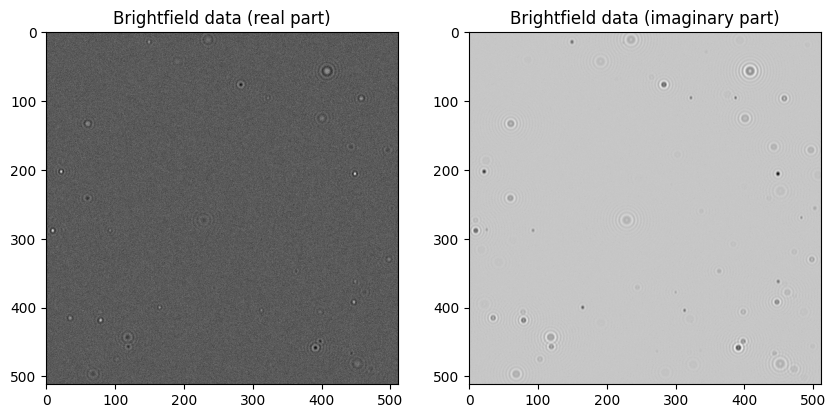

In [256]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(data[...,0], cmap="gray")
plt.title("Brightfield data (real part)")
plt.subplot(122)
plt.imshow(data[...,1], cmap="gray")
plt.title("Brightfield data (imaginary part)")
plt.show()

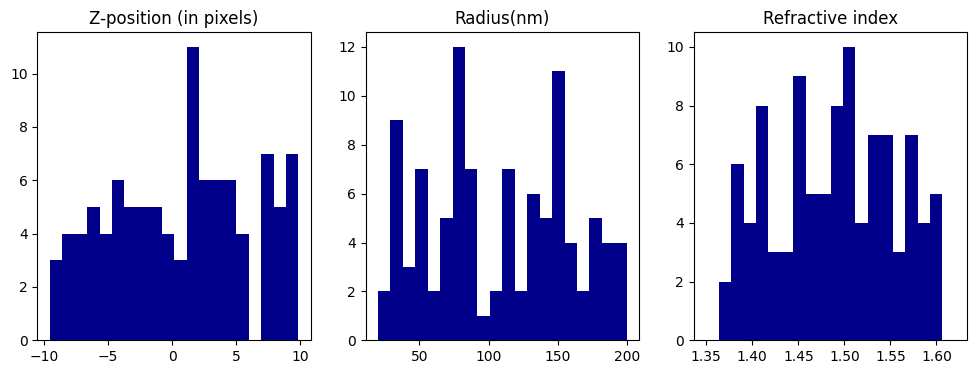

In [257]:
#Subplot of the distribution of the labels
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(labels[:,2], bins=20, color = 'darkblue')
plt.title("Z-position (in pixels)")
plt.subplot(132)
plt.hist(labels[:,3]*1e9, bins=20, color = 'darkblue', range=(20, 200))
plt.title("Radius(nm)")
plt.subplot(133)
plt.hist(labels[:,4], bins=20, color = 'darkblue', range=(1.35, 1.62))
plt.title("Refractive index")
plt.show()


### 2.1 Detecting particles using a classical method


#### 2.1.1 - Radial Variance Transform
xxx

In [258]:
import rvt # We import the radial variance method. Cite xxx
import skimage

In [298]:
#Apply Radial Variance Transform of image
rmin, rmax = 4, 25

def rvt_pipeline(data, rmin = 4, rmax = 25, th_scale = 0.3, min_distance = 5):
    
    #Apply Radial Variance Transform of image
    det = rvt.rvt(data[...,1], rmin = rmin, rmax = rmax)

    #Local max of the transformed image.
    blobs = skimage.feature.peak_local_max(det, min_distance=min_distance)
    blobs = np.stack([blobs[:,0], blobs[:,1]], axis=-1)

    #Extract detections that have a high enough value
    detections = []
    th = np.mean(det)*th_scale
    for blob in blobs:
        if np.mean(det[blob[0]-2:blob[0]+2, blob[1]-2:blob[1]+2]) > th:
            detections.append(blob)

    #Convert to numpy array and rename
    detections_rvt = np.array(detections)
    return detections_rvt

In [356]:
detections_rvt = rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = 0.3)

#### 2.1.2 - Visualizing the detections from RVT
xxx

Text(0.5, 1.0, 'Detections with Radial Variance Transform')

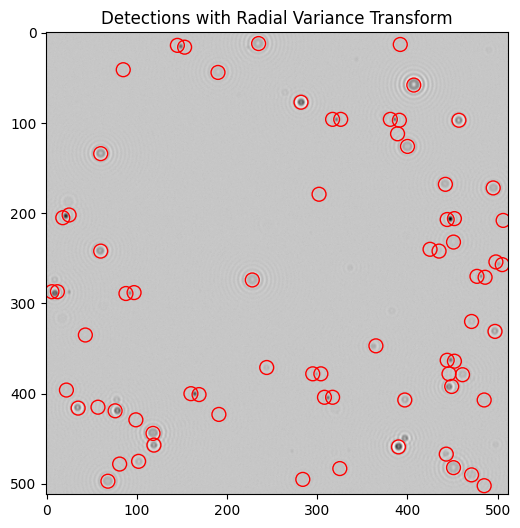

In [357]:
plt.figure(figsize=(6,6))
plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections_rvt[:,1], detections_rvt[:,0], s = 100, facecolors='none', edgecolors='r')
plt.title("Detections with Radial Variance Transform") 

### 2.2 Detecting particles using LodeSTAR model

xxx

#### 2.2.1  Prepare the Training Crop
We will use a single crop of a single particle to train the neural network.

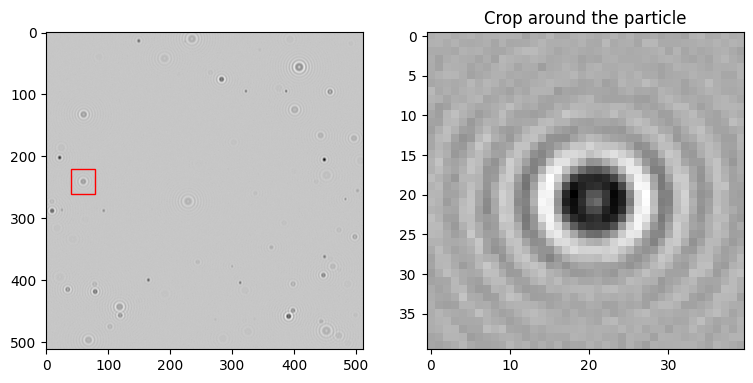

In [261]:
import matplotlib.patches as patches

crop_size = 40
labels_idx = 14

# We crop the image around the particle (based on the labels) - One could also use the detections or manually select a particle.
crop_x0 = int(labels[labels_idx, 0] - crop_size/2)
crop_y0 = int(labels[labels_idx, 1] - crop_size/2)

crop = data[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size, :]

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.imshow(data[...,1], cmap="gray")
plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                      linewidth=1, edgecolor="r",
                                      facecolor="none"))

plt.subplot(1, 2, 2)
plt.title("Crop around the particle")
plt.imshow(crop[...,1], cmap="gray")

plt.show()

#### 2.2.1  Prepare pipeline and train model
We will create a pipeline for training the LodeSTAR model

In [273]:
IMAGE_SIZE = 40
PADDING = 64
WAVELENGTH = 633e-9
RESOLUTION = 1.14e-7


#For z-propagation
crop_propagation_forward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, 1e-7, RESOLUTION, WAVELENGTH)
crop_propagation_backward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, -1e-7, RESOLUTION, WAVELENGTH)


##################################
import numpy as np
import torch

training_pipeline = (
    dt.Value(crop)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, lambda:np.random.randint(-10, 10)) 
    >> dt.InverseFourierTransform() 
    >> dt.Multiply(lambda: np.random.uniform(0.5, 1.5))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 1e-3)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, 
                                      replace=False)

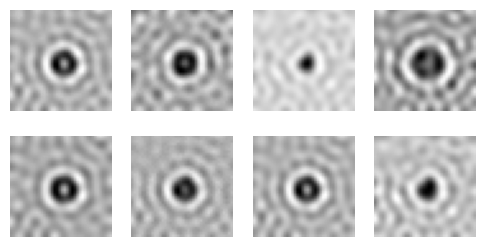

In [274]:
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(6, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,1], cmap="gray")
    plt.axis("off")

In [283]:

lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=150)
trainer.fit(lodestar, dataloader)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                       | Pa

Epoch 99: 100%|██████████| 50/50 [00:03<00:00, 13.65it/s, v_num=10, train_between_image_disagreement_step=0.0222, train_within_image_disagreement_step=0.0144, train_between_image_disagreement_epoch=0.0275, train_within_image_disagreement_epoch=0.0185] 


#### 2.2.1  Visualize result from trained LodeSTAR model

xxx

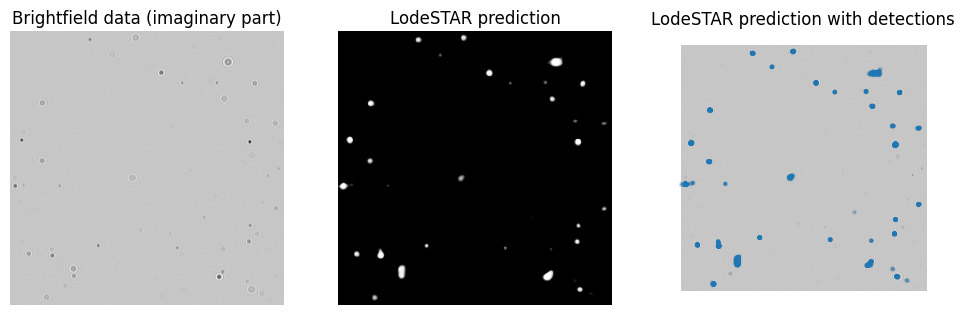

In [284]:

torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Brightfield data (imaginary part)")
plt.imshow(data[...,1], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("LodeSTAR prediction")
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("LodeSTAR prediction with detections")
plt.imshow(data[...,1], cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

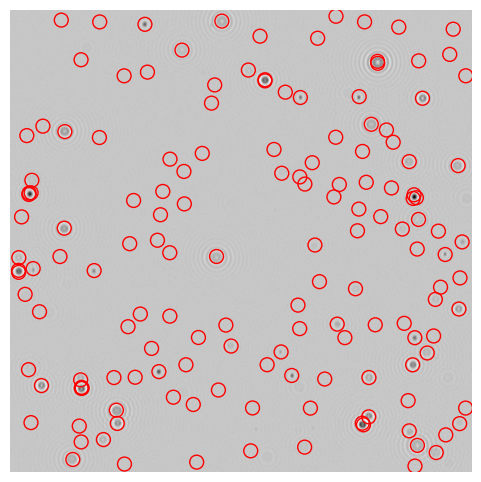

In [313]:
alpha = 0.5
beta = 0.3
cutoff = 0.90
mode = "quantile"#"constant"

plt.figure(figsize=(6, 6))
torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                mode=mode, cutoff=cutoff)[0]

plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis("off")

plt.show()

### 2.3 Comparison between LodeSTAR and Radial Variance Transform

Both methods have a dependence on the threshold chosen. Down below we analyze the True Positive(TP), False Positive(FP), False Negative(FN) and the F1 Score, as well as constructing a ROC curve.

In [390]:
import scipy

radius = 6 # Radius of the particle in pixels
centroids = labels[:, :2] # We use the labels as the ground truth
n_values = 250 # Number of values to test the threshold

# We create the arrays to store the results
TP_l, FP_l, FN_l, F1_l = np.zeros(n_values), np.zeros(n_values), np.zeros(n_values), np.zeros(n_values)
TP_c, FP_c, FN_c, F1_c = np.zeros(n_values), np.zeros(n_values), np.zeros(n_values), np.zeros(n_values)
mask = np.zeros_like(data[...,1])

In [391]:
def add_bin_circles(positions, radius, image):
    """Add circles to an image."""
    im = image.copy()
    for position in positions:
        rr, cc = skimage.draw.disk(position, radius)
        im[rr, cc] = 1
    return im

In [392]:
GT_particles = add_bin_circles(centroids, radius, mask)

Text(0.5, 1.0, 'Ground truth particles')

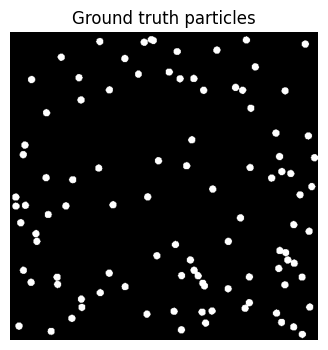

In [393]:
plt.figure(figsize=(4, 4))
plt.imshow(GT_particles, cmap="gray")
plt.axis("off")
plt.title("Ground truth particles")

In [419]:
### For LodeSTAR
cutoff_values_l = np.linspace(0.5, 0.999, n_values)

alpha = 0.5
beta = 0.3
mode = "quantile"

for i, cutoff in enumerate(cutoff_values_l):
    if i % 50 == 0: print(f"Testing cutoff {i}/{n_values}")
    
    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                                    mode=mode, cutoff=cutoff)[0]

    #Remove detections that are too close to the border with size radius
    detections = detections[(detections[:,0] > radius) & (detections[:,0] < data.shape[0] - radius) & 
                            (detections[:,1] > radius) & (detections[:,1] < data.shape[1] - radius)]

    # We create the mask with the detections
    mask_tmp = add_bin_circles(detections, radius, mask)

    # True positives - Overlap between the mask and the ground truth
    TP = np.sum(mask_tmp * GT_particles)
    # False positives - Detections that are not in the ground truth
    FP = np.sum(mask_tmp) - TP
    # False negatives - Ground truth particles that were not detected
    FN = np.sum(GT_particles) - TP
    # F1 score
    F1 = 2 * TP / (2 * TP + FP + FN)

    TP_l[i] = TP
    FP_l[i] = FP
    FN_l[i] = FN
    F1_l[i] = F1

Testing cutoff 0/250
Testing cutoff 50/250
Testing cutoff 100/250
Testing cutoff 150/250
Testing cutoff 200/250


In [420]:
### For RVT
cutoff_values_c = np.linspace(-0.5, 3, n_values)

for i, cutoff in enumerate(cutoff_values_c):
    if i % 50 == 0: print(f"Testing cutoff {i}/{n_values}")
    
    detections = rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = cutoff)

    #Remove detections that are too close to the border with size radius
    detections = detections[(detections[:,0] > radius) & (detections[:,0] < data.shape[0] - radius) & 
                            (detections[:,1] > radius) & (detections[:,1] < data.shape[1] - radius)]

    # We create the mask with the detections
    mask_tmp = add_bin_circles(detections, radius, mask)

    # True positives - Overlap between the mask and the ground truth
    TP = np.sum(mask_tmp * GT_particles)
    # False positives - Detections that are not in the ground truth
    FP = np.sum(mask_tmp) - TP
    # False negatives - Ground truth particles that were not detected
    FN = np.sum(GT_particles) - TP
    # F1 score
    F1 = 2 * TP / (2 * TP + FP + FN)

    TP_c[i] = TP
    FP_c[i] = FP
    FN_c[i] = FN
    F1_c[i] = F1

Testing cutoff 0/250


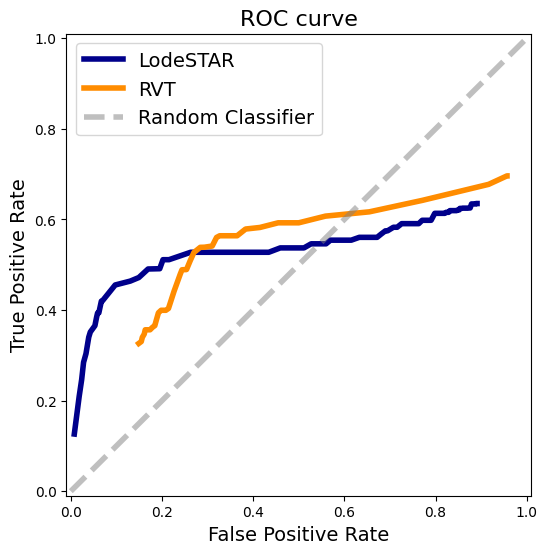

In [ ]:
# ROC
TPR_l = TP_l / (TP_l + FN_l)
FPR_l = FP_l / (FP_l + FN_l)

TPR_c = TP_c / (TP_c + FN_c)
FPR_c = FP_c / (FP_c + FN_c)

plt.figure(figsize=(6, 6))
plt.plot(FPR_l, TPR_l, label="LodeSTAR", linestyle="-", color = 'darkblue', linewidth=4)
plt.plot(FPR_c, TPR_c, label="RVT", linestyle="-", color = 'darkorange', linewidth=4)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier", linewidth=4, alpha = 0.5)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.legend(fontsize=14)
plt.xlabel("False Positive Rate", fontsize=14) 
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC curve", fontsize=16)
plt.show()


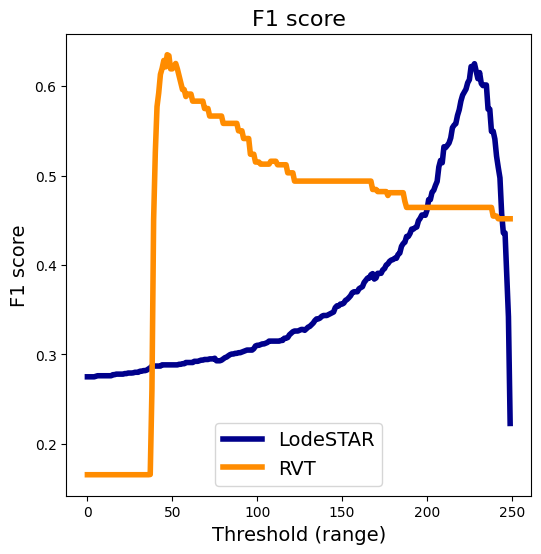

In [ ]:
# F1 score
plt.figure(figsize=(6, 6))
plt.plot(np.arange(n_values), F1_l, label="LodeSTAR", linestyle="-", color = 'darkblue', linewidth=4)
plt.plot(np.arange(n_values), F1_c, label="RVT", linestyle="-", color = 'darkorange', linewidth=4)
plt.legend(fontsize=14)
plt.xlabel("Threshold (range)", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.title("F1 score", fontsize=16)
plt.show()

In [ ]:
#Find the best threshold for LodeSTAR
best_threshold_l = cutoff_values_l[np.argmax(F1_l)]
print(f"Best threshold for LodeSTAR: {best_threshold_l}")

#Find the best threshold for RVT
best_threshold_c = cutoff_values_c[np.argmax(F1_c)]
print(f"Best threshold for RVT: {best_threshold_c}")


Best threshold for LodeSTAR: 2.7048192771084336


In [9]:
pauis

NameError: name 'pauis' is not defined

### 2.2 Extract regions of interest around these detections

In [ ]:
def get_rois(data, positions, padsize):
    rois = []
    for pos in positions:
        pos[0] = int(pos[0])
        pos[1] = int(pos[1])

        #Check if the roi is out of bounds
        if pos[1]-padsize < 0 or pos[1]+padsize >= data.shape[0] or pos[0]-padsize < 0 or pos[0]+padsize >= data.shape[1]:
            continue

        roi = data[pos[0]-padsize:pos[0]+padsize, pos[1]-padsize:pos[1]+padsize,:]
        rois.append(roi)
    return np.stack(rois)

In [ ]:
rois = get_rois(data, blobs, 16)
rois.shape

(210, 32, 32, 2)

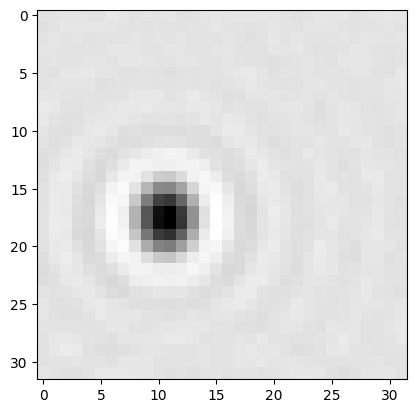

In [ ]:
plt.imshow(rois[6,...,1], cmap="gray")

### 2.1 Defining the optical system

xxx

In [ ]:
IMAGE_SIZE = 32
NA = 1.3
MAGNIFICATION = 1
WAVELENGTH = 633e-9
RESOLUTION = 1.14e-7

In [ ]:
optics = dt.Darkfield(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    #return_field=True, 
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination_angle=np.pi
)

### 2.2 Defining the particle

xxx

In [ ]:
RADIUS = 50e-9
REFRACTIVE_INDEX = 1.4
PADDING = 64

In [ ]:
particle = dt.MieSphere(
    radius=lambda: RADIUS,
    refractive_index=lambda: REFRACTIVE_INDEX,
    position=(IMAGE_SIZE / 2,) * 2,
    L=100,
)

### 2.3 Defining the dataset

We define a dataset with the particle properties imaged in the optical setup.

In [ ]:

training_data = optics(particle) 
#training_data = (imaged_particle >> dt.Real()) & (imaged_particle >> dt.Imag())
#training_data = training_data >> dt.Merge(lambda: lambda x: np.concatenate( [np.array(_x) for _x in x], axis=-1 ))

In [ ]:
training_data.store_properties()

In [ ]:
X2 = training_data.update().resolve()

In [ ]:
X2.get_property('radius')

5e-08

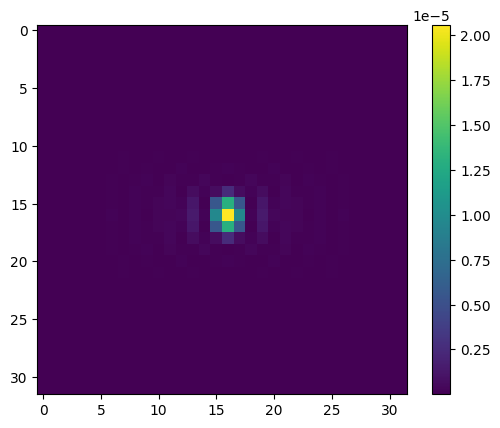

In [ ]:
plt.imshow(training_data.update().resolve())
plt.colorbar()

In [ ]:
paus

NameError: name 'paus' is not defined

In [ ]:
#For z-propagation
crop_propagation_forward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, 1e-7, RESOLUTION, WAVELENGTH)
crop_propagation_backward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, -1e-7, RESOLUTION, WAVELENGTH)

# Augmentation arguments
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randint(-2, 2),
    )

# Augmentation pipeline
group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 1e-5)
)

# Equivariance for the model
equivariance = (
     dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >>dt.models.lodestar.TranslationalEquivariance(args.translate)
    )

##################################

import numpy as np
import torch

training_pipeline = (
    dt.Value(training_data)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, lambda:np.random.randint(-3, 3)) 
    >> dt.InverseFourierTransform() 
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, 
                                      replace=False)


In [ ]:
import deeptrack.deeplay as dl 

dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=50)
trainer.fit(lodestar, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estim

Epoch 199: 100%|██████████| 50/50 [00:01<00:00, 45.85it/s, v_num=1, train_between_image_disagreement_step=0.747, train_within_image_disagreement_step=7.73e-5, train_between_image_disagreement_epoch=0.870, train_within_image_disagreement_epoch=8.94e-5]  

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 50/50 [00:01<00:00, 45.33it/s, v_num=1, train_between_image_disagreement_step=0.747, train_within_image_disagreement_step=7.73e-5, train_between_image_disagreement_epoch=0.870, train_within_image_disagreement_epoch=8.94e-5]


AttributeError: 'numpy.ndarray' object has no attribute 'properties'

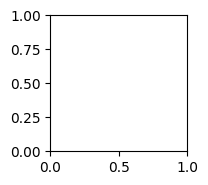

In [ ]:
val = training_data.update()()
training_set = dt.Value(lambda: np.array(val))

#3x3 grid of augmented images
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    (training_set >> group).update().plot(cmap = 'gray')
    plt.axis('off')

### 2.4 Training detection model (LodeSTAR)

In [ ]:
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    2,
    (group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)

In [ ]:

with generator:
    model = dt.models.LodeSTAR(input_shape=(None, None, 2), num_outputs=2)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    
    loss = model.fit(generator, epochs=50, steps_per_epoch=100)


Generating 201 / 200 samples before starting training
Epoch 1/50
100/100 [==============================] - 4s 17ms/step - total_loss: 2.0311 - consistency_loss: 1.2046
Epoch 2/50
100/100 [==============================] - 2s 16ms/step - total_loss: 1.9200 - consistency_loss: 1.1470
Epoch 3/50
100/100 [==============================] - 1s 12ms/step - total_loss: 1.8751 - consistency_loss: 1.0425
Epoch 4/50
100/100 [==============================] - 2s 15ms/step - total_loss: 2.2075 - consistency_loss: 0.9319
Epoch 5/50
100/100 [==============================] - 2s 17ms/step - total_loss: 1.8752 - consistency_loss: 0.9286
Epoch 6/50
100/100 [==============================] - 2s 17ms/step - total_loss: 1.5884 - consistency_loss: 0.7163
Epoch 7/50
100/100 [==============================] - 2s 17ms/step - total_loss: 1.4570 - consistency_loss: 0.5994
Epoch 8/50
100/100 [==============================] - 2s 16ms/step - total_loss: 1.3539 - consistency_loss: 0.5199
Epoch 9/50
100/100 [======

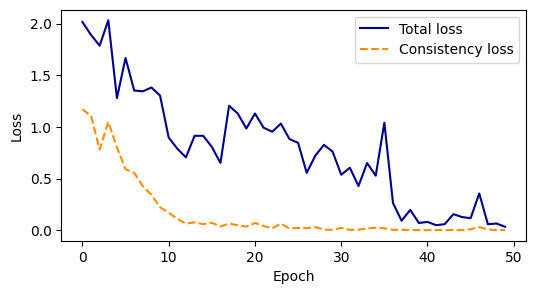

In [ ]:
plt.figure(figsize = (6,3))
plt.plot(loss.history["total_loss"], color="darkblue", label="Total loss")
plt.plot(loss.history["consistency_loss"], linestyle="--", color="darkorange", label="Consistency loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
#3x3 grid of augmented images
plt.figure(figsize=(6, 6))
for i in range(9):
    validation_data = training_data.update()()
    ground_truth_position = validation_data.get_property("position") 

    prediction = model.predict_and_pool(np.expand_dims(validation_data, axis = 0))

    plt.subplot(3, 3, i+1)
    plt.imshow(validation_data[...,0], cmap="gray")
    plt.scatter(prediction[0, 1], prediction[:, 0], s=800, linewidths=4, marker="o", facecolors="none", edgecolors="darkblue")
    plt.axis("off")

AttributeError: 

<Figure size 600x600 with 0 Axes>

## 3. Quantification in brightfield

### 3.1 Defining the optical system

xxx

In [ ]:
IMAGE_SIZE = 32
NA = 1.3
MAGNIFICATION = 1
WAVELENGTH = 633e-9
RESOLUTION = 2*1.14e-7

In [ ]:
optics = dt.Brightfield(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    return_field=True, 
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination_angle = 0
)

### 3.2 Defining the particle(s)

In [ ]:
RADIUS_RANGE = (25e-9, 200e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [ ]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 2,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
)

### 3.3 Create dataset of particles

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. The amplitude of the noise is determined by the dummy property `level`, which is explicitly shared between the two features. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [ ]:
real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: np.random.rand() * 0.02,
)

noise = real_noise >> dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.03j,
    real_sigma=real_noise.sigma
)

def func():
    def inner(image):
        image = image - 1
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func)

We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [ ]:
noisy_dataset = optics(particle >> noise) >> complex_to_float
clean_dataset = optics(particle) >> complex_to_float

dataset = noisy_dataset & clean_dataset

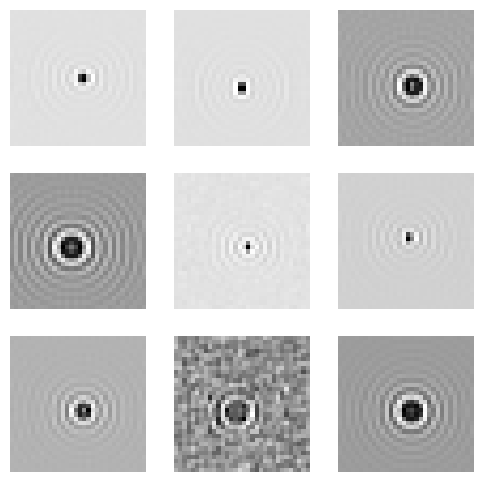

In [ ]:
#3x3 grid of augmented images
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = dataset.update().resolve()
    plt.imshow(img[0][...,1], cmap="gray")
    plt.axis('off')

### 3.4 Defining the training label

We extract the parameters we want the network to learn. This is the integrated signal.

In [ ]:
def get_label(image):
    return np.array(np.sum(image[1][...,1]))

In [ ]:
def get_polarizability(image):
    r = image[0].get_property("radius")
    n = image[0].get_property("refractive_index") - 1.33
    return np.array(4/3 * np.pi * r**3 * n)


AttributeError: 'numpy.ndarray' object has no attribute 'get_property'

In [ ]:
def batch_function(image):
    return np.array(image[0])

AttributeError: 'numpy.ndarray' object has no attribute 'get_property'

### 3.5 Defining quantification model (2DCNN)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

model = dt.models.Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 2),
    conv_layers_dimensions=(16, 32, 64),
    dense_layers_dimensions=(64, 64),
    steps_per_pooling=2,
    number_of_outputs=1,
    dropout=(.2, .2),
    loss="mae",
    optimizer="adam",
    dense_block=dt.layers.DenseBlock(activation="relu")
)

model.summary()

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        304       
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 32, 32, 16)       0         
 ropout2D)                                                       
                                                             

### 3.6 Training quantification model

In [ ]:
TRAIN_MODEL = True

validation_set_size = 256
validation_set = []
validation_labels = []
for _ in range(validation_set_size):
    image = dataset.update().resolve()

    validation_set.append(image[0])
    validation_labels.append(get_label(image))

validation_set = np.array(validation_set)
validation_labels = np.array(validation_labels)

In [ ]:
model.fit(
    validation_set, 
    validation_labels,
    epochs=1,
    verbose=1
)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


8/8 [==============================] - 3s 5ms/step - loss: 0.0137


In [ ]:
if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        dataset,
        batch_function=batch_function,
        label_function=get_label,
        min_data_size=int(1e2),
        max_data_size=int(1e3),
        batch_size=32,
        max_epochs_per_sample=33
    )

    with generator:
        h = model.fit(
            generator,
            validation_data=(
                np.array(validation_set), 
                np.array(validation_labels)
            ),
            epochs=500,
        )
    
    plt.figure(figsize=(6, 3))
    plt.plot(h.history["val_loss"], label="Validation loss")
    plt.plot(h.history["loss"], label="Training loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")



Generating 108 / 100 samples before starting training


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
N_samples = 256
Signal = []
Pol = []
Prediction = []

for n in range(N_samples):

    image = dataset.update().resolve()
    integrated_signal = get_label(image)
    polarizability = get_polarizability(image)

    prediction = model.predict(np.expand_dims(image[0], axis=0))

    Signal.append(integrated_signal)
    Pol.append(polarizability)
    Prediction.append(prediction[0])


1/1 [==============================] - 0s 22ms/step


In [ ]:
Signal = np.array(Signal)
Pol = np.array(Pol)
Prediction = np.array(Prediction)


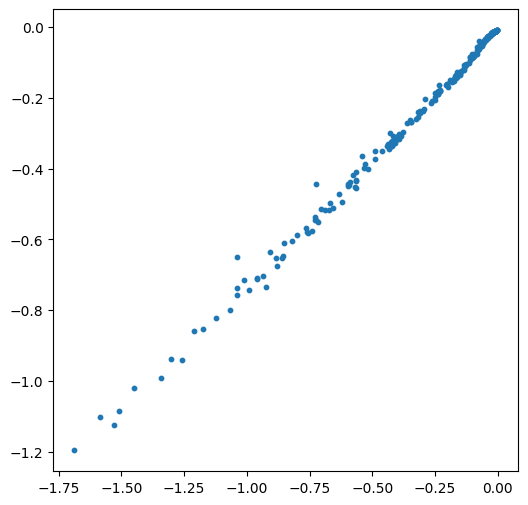

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Signal, Prediction, s=10)
plt.show()

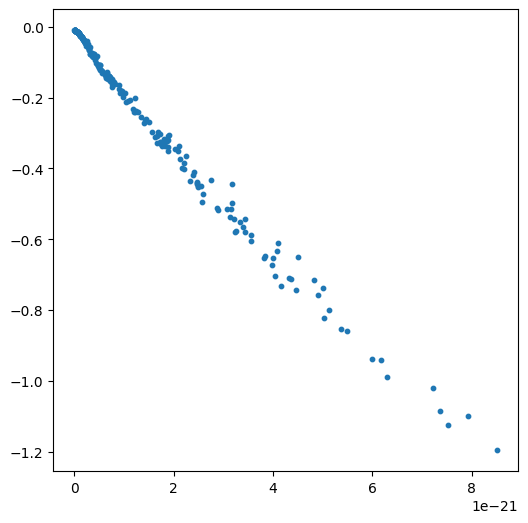

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Pol, Prediction, s=10)
plt.show()

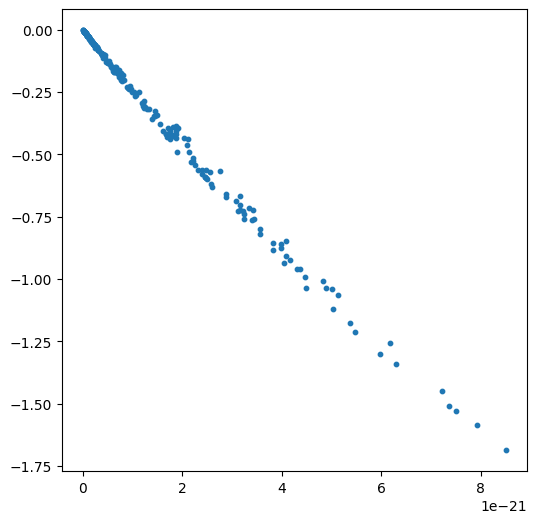

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Pol, Signal, s=10)
plt.show()

## 4. Combining detection and quantification in brightfield